In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import scipy

from guided_diffusion.blind_condition_methods import get_conditioning_method
from guided_diffusion.measurements import get_operator, get_noise

# Here replaces the regular unet by our trained unet
# from guided_diffusion.unet import create_model
import guided_diffusion.diffusion_model_unet 
import guided_diffusion.unet

from guided_diffusion.gaussian_diffusion import create_sampler
from data.dataloader import get_dataset, get_dataloader
from motionblur.motionblur import Kernel
from util.img_utils import Blurkernel, clear_color
from util.logger import get_logger
from skimage.restoration import richardson_lucy, wiener, unsupervised_wiener
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve

device = 'cuda'
    
name = 'ellipse'
root = './data/ellipse_samples/'

transform = transforms.Compose([transforms.ToTensor()])
dataset = get_dataset(name=name, root=root, transforms=transform)
loader = get_dataloader(dataset, batch_size=1, num_workers=0, train=False)

# set seed for reproduce
np.random.seed(123)



def wiener_deconv(x_0_hat, steps, **kwargs):
    img = x_0_hat['img'].numpy().astype(np.float32)
    kernel = x_0_hat['kernel'].numpy().astype(np.float32)
    
    deconv_img = wiener(image=img, balance=1.0, psf=kernel, clip=False)
    # deconv_img, _ = unsupervised_wiener(image=img.numpy(), psf=kernel.numpy(), clip=False)
    
    x_0_hat['img'] = torch.from_numpy(deconv_img).to(device)
    
    return x_0_hat

# def blind_mlem(x_0_hat, steps, clip, filter_epsilon, **kwargs):
#     img = x_0_hat['img'].numpy()
#     psf = x_0_hat['kernel'].numpy()
    
#     float_type = img.dtype
#     image = img.astype(float_type, copy=False)
#     # im_deconv = np.full(img.shape, 0.5, dtype=float_type)
#     im_deconv = image.copy()
#     im_mirror = np.flip(im_deconv)
#     # psf_deconv = np.full(psf.shape, 0.5, dtype=float_type)
#     psf_deconv = psf.copy()
#     psf_deconv /= psf.sum()
#     psf_mirror = np.flip(psf_deconv)

#     # Small regularization parameter used to avoid 0 divisions
#     eps = 1e-12

#     for _ in range(steps):
        
#         # Update the kernel
        
#         conv = convolve(im_deconv, psf_deconv, mode='same') + eps
        
#         if filter_epsilon:
#             relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
#         else: 
#             relative_blur = image / conv
        
#         conv2 = convolve(relative_blur, im_mirror, mode='same') + eps
#         print(conv2.shape)
#         psf_deconv *= conv2
#         coeff = convolve(np.ones_like(psf_deconv), im_deconv, mode='same') + eps
#         psf_deconv /= coeff
#         psf_mirror = np.flip(psf_deconv)
        
#         # Update the image
#         conv = convolve(im_deconv, psf_deconv, mode='same') + eps
#         if filter_epsilon:
#             relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
#         else:
#             relative_blur = image / conv
#         im_deconv *= convolve(relative_blur, psf_mirror, mode='same')
#         coeff = convolve(np.ones_like(im_deconv), psf_mirror, mode='same') + eps
#         im_deconv /= coeff
#         im_mirror = np.flip(im_deconv)
        
#     if clip:
#         im_deconv[im_deconv > 1] = 1
#         im_deconv[im_deconv < -1] = -1
    
#     x_0_hat['img'] = torch.from_numpy(im_deconv).to(device)
#     x_0_hat['kernel'] = torch.from_numpy(psf_deconv).to(device)
    
#     return x_0_hat

import numpy as np
from scipy.signal import fftconvolve

def richardson_lucy_blind(image, psf, original, num_iter=50):    
    im_deconv = original.copy()    # init output
    for i in range(num_iter):
        psf_mirror = np.flip(psf)
        conv = fftconvolve(im_deconv, psf, mode='same')
        relative_blur = image / conv
        im_deconv *= fftconvolve(relative_blur, psf_mirror, mode='same')
        im_deconv_mirror = np.flip(im_deconv)
        psf *= fftconvolve(relative_blur, im_deconv_mirror, mode='same')    
    return im_deconv, psf

def blind_mlem(x_0_hat, steps, clip, filter_epsilon, **kwargs):
    img = x_0_hat['img'].numpy()
    psf = x_0_hat['kernel'].numpy()
    
    im_deconv, psf_deconv = richardson_lucy_blind(img, psf, img, num_iter=steps)
    x_0_hat['img'] = torch.from_numpy(im_deconv).to(device)
    x_0_hat['kernel'] = torch.from_numpy(psf_deconv).to(device)
    
    return x_0_hat
    

In [2]:
from scipy.signal import convolve
import numpy as np
import torch

def mlem(observation, x_0_hat, steps, clip, filter_epsilon, **kwargs):
    img = x_0_hat['img']
    kernel = x_0_hat['kernel']
    
    image = observation.cpu().numpy().astype(np.float32, copy=True)
    psf = kernel.cpu().numpy().astype(np.float32, copy=False)
    # im_deconv = np.full(image.shape, 0.5, dtype=np.float32)
    im_deconv = img.cpu().numpy().astype(np.float32, copy=True)
    psf_mirror = np.flip(psf)

    # Small regularization parameter used to avoid 0 divisions
    eps = 1e-6

    for _ in range(steps):
        conv = convolve(im_deconv, psf, mode='same', method='fft') + eps
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
        else:
            relative_blur = image / conv
        im_deconv *= convolve(relative_blur, psf_mirror, mode='same', method='fft')

    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1

    x_0_hat['img'] = torch.from_numpy(im_deconv).to(device)
    
    return x_0_hat

In [3]:
import torch
import torch.nn.functional as F
import numpy as np

def mlem_gpu(observation, x_0_hat, steps, clip, filter_epsilon, device):
    img = x_0_hat['img']
    # kernel = x_0_hat['kernel'].repeat(1,3,1,1)
    kernel = x_0_hat['kernel']
    

    image = observation.to(torch.float32).clone().to(device)
    psf = kernel.to(torch.float32).clone().to(device)
    im_deconv = img.to(torch.float32).clone().to(device)
    psf_mirror = torch.flip(psf, dims=[0, 1])

    # Small regularization parameter used to avoid 0 divisions
    eps = 1e-12
    with torch.no_grad():
        pad = (psf.size(2) // 2, psf.size(2) // 2, psf.size(3) // 2, psf.size(3) // 2)
        for _ in range(steps):
            conv = F.conv2d(F.pad(im_deconv, pad, mode='replicate'), psf) + eps
            if filter_epsilon:
                relative_blur = torch.where(conv < filter_epsilon, torch.tensor(0.0, device=device), image / conv)
            else:
                relative_blur = image / conv
            im_deconv *= F.conv2d(F.pad(relative_blur, pad, mode='replicate'), psf_mirror)

        if clip:
            im_deconv = torch.clamp(im_deconv, -1, 1)

        x_0_hat['img'] = im_deconv.to(device)
    
    return x_0_hat


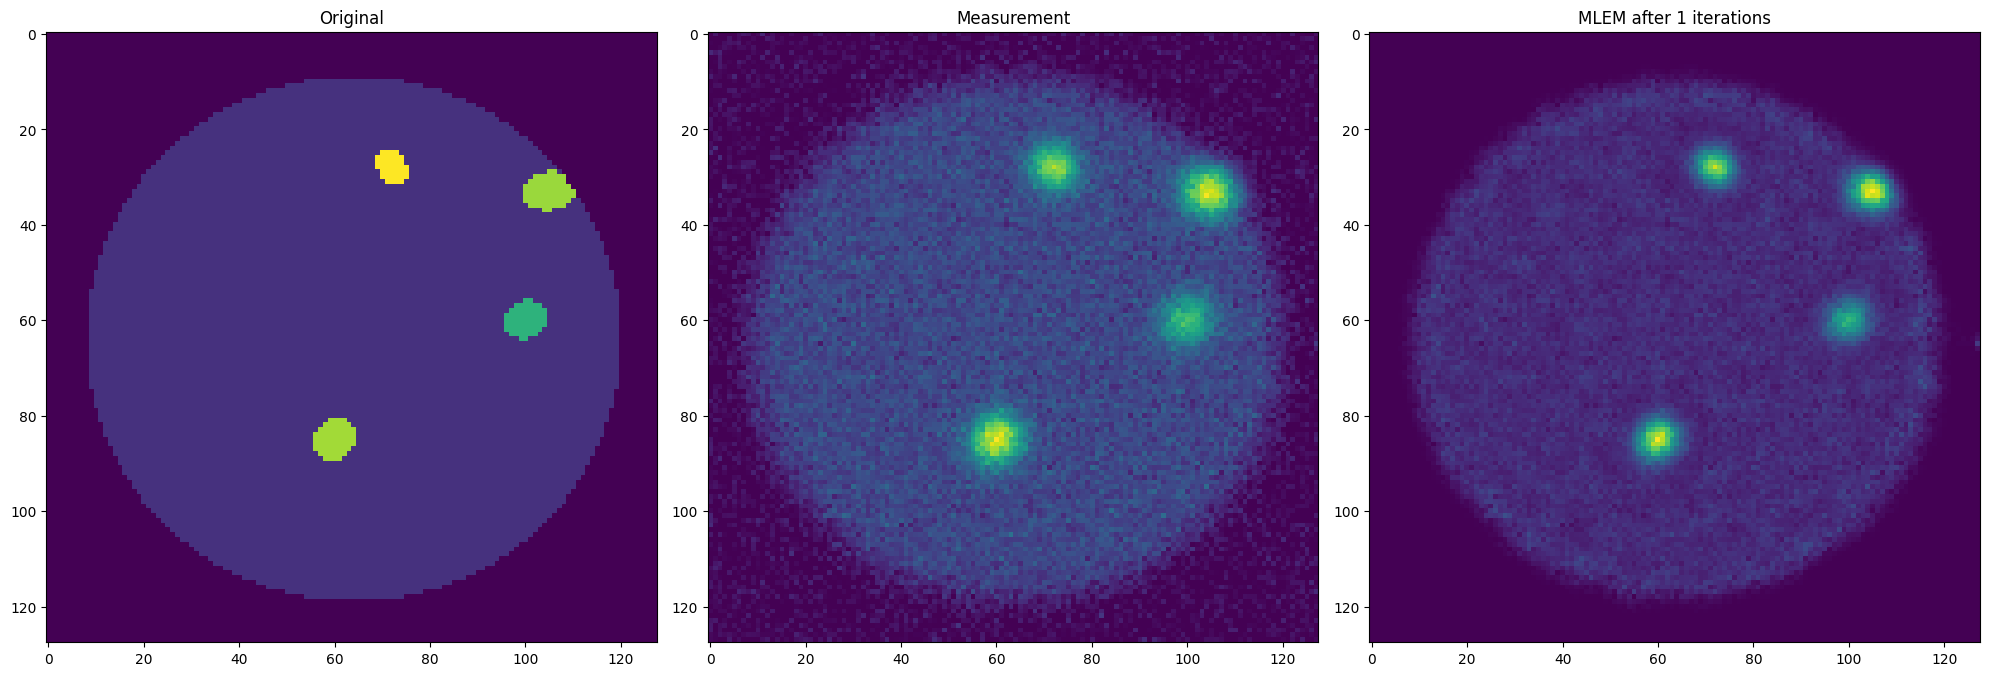

In [12]:
kernel_size = 61
kernel_std = 3.0
noise_level = 0.02

operator = get_operator(name='gaussian_blur', kernel_size=kernel_size, intensity=kernel_std, device=device)
noiser = get_noise(name='gaussian', sigma=noise_level)

# Do Inference
for i, ref_img in enumerate(loader):
    
    conv = Blurkernel('gaussian', kernel_size=kernel_size, std=kernel_std, device=device)
    kernel = conv.get_kernel().type(torch.float32)
    kernel = kernel.to(device).view(1, 1, kernel_size, kernel_size)

    ref_img = ref_img.to(device)
    y_conv = operator.forward(ref_img)
    y = noiser(y_conv)

    y_mlem = y.clone()
    y_mlem = torch.clamp(y_mlem, min=0)
    
    steps = 1
    
    # Call mlem
    # x_0_hat={'img': torch.ones_like(y_mlem), 'kernel': kernel}
    # x_0_hat={'img': y_mlem, 'kernel': kernel}
    
    
    # for _ in range(steps):
    #     x_0_hat_mlem = mlem(y_mlem, x_0_hat, steps=100, clip=False, filter_epsilon=1e-2)
    #     x_0_hat = x_0_hat_mlem
    
    x_0_hat={'img': y_mlem, 'kernel': kernel}
    
    for _ in range(steps):
        x_0_hat_mlem_gpu = mlem_gpu(y_mlem, x_0_hat, steps=10, clip=False, filter_epsilon=1e-2, device=device)
        x_0_hat = x_0_hat_mlem_gpu
        
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    # Display x
    ax0 = axes[0]
    im0 = ax0.imshow(ref_img.squeeze().cpu().numpy())
    ax0.set_title('Original')
    
    # Display y
    ax1 = axes[1]
    im1 = ax1.imshow(y_mlem.squeeze().detach().cpu().numpy())
    ax1.set_title('Measurement')

    # Display y after MLEM
    ax2 = axes[2]
    im2 = ax2.imshow(x_0_hat_mlem_gpu['img'].squeeze().detach().cpu().numpy())
    ax2.set_title(f'MLEM after {steps} iterations')


    # Adjust the layout
    plt.tight_layout()
    plt.show()
    break
plt.show()